In [1]:
from pprint import pprint
from pathlib import Path
import pandas as pd
import qlib
import os
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord, SigAnaRecord
from qlib.contrib.report import analysis_model, analysis_position
from qlib.data import D
from qlib.data.dataset import TSDataSampler

qlib.init(provider_uri='~/.qlib/qlib_data/cn_data')

/data2/linaiqi/anaconda3/envs/qlib/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[20558:MainThread](2024-10-04 09:46:48,049) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[20558:MainThread](2024-10-04 09:46:48,054) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[20558:MainThread](2024-10-04 09:46:48,055) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/data2/linaiqi/.qlib/qlib_data/cn_data')}


In [2]:
MARKET='csi100'
BENCHMARK = "SH000300"
# EXP_NAME = 'csi100_TCN'

<AxesSubplot:xlabel='datetime'>

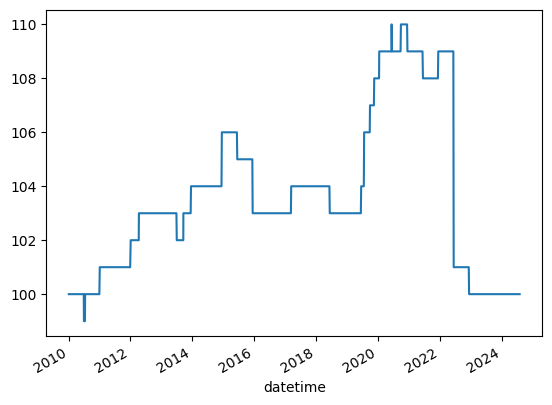

In [3]:
df = D.features(D.instruments(MARKET), ["$close"], start_time="2010-01-01", end_time="2024-08-01")
df.groupby("datetime").size().plot()

In [4]:
handler_kwargs = {
    "start_time": "2010-01-01",
    "end_time": "2024-08-01",
    # "fit_start_time": "2010-01-01",
    # "fit_end_time": "2020-12-31",
    "instruments": MARKET,
    # 'infer_processors': [
    #     {
    #     'class': 'Fillna',
    #     'kwargs': {
    #         'fields_group': 'feature'
    #         }
    #     }
    # ],
    'learn_processors': [
        {'class': 'ZScoreNorm',
          'kwargs':
              {'fit_start_time': '2010-01-01',
               'fit_end_time': '2011-01-01'}
        }
    ],
    'data_loader': {
        "class": "QlibDataLoader",
        "module_path": "qlib.data.dataset.loader",
        "kwargs": {
            'config': (
                ['Ref($close, 4)', 'Ref($close, 3)', 'Ref($close, 2)', 'Ref($close, 1)', '$close', 
                 'Ref($close, -1) / $close - 1'],
                ['c4', 'c3', 'c2', 'c1', 'c0', 'label']
            )
        },
    }

}
handler_conf = {
    "class": "DataHandlerLP",
    "module_path": "qlib.data.dataset.handler",
    "kwargs": handler_kwargs,
}
hd = init_instance_by_config(handler_conf)

[20558:MainThread](2024-10-04 09:46:50,589) INFO - qlib.timer - [log.py:127] - Time cost: 1.088s | Loading data Done
[20558:MainThread](2024-10-04 09:46:50,635) INFO - qlib.timer - [log.py:127] - Time cost: 0.042s | ZScoreNorm Done
[20558:MainThread](2024-10-04 09:46:50,636) INFO - qlib.timer - [log.py:127] - Time cost: 0.045s | fit & process data Done
[20558:MainThread](2024-10-04 09:46:50,638) INFO - qlib.timer - [log.py:127] - Time cost: 1.138s | Init data Done


In [5]:
dataset_conf = {
    "class": "DatasetH",
    "module_path": "qlib.data.dataset",
    "kwargs": {
        "handler": hd,
        "segments": {
            "train": ("2010-01-01", "2020-12-31"),
            "valid": ("2021-01-01", "2022-12-31"),
            "test": ("2023-01-01", "2024-08-01"),
        },
        'step_len': 20
    },
}
dataset = init_instance_by_config(dataset_conf)

In [6]:
dataset.prepare("train")

c4         c3         c2         c1         c0  \
datetime   instrument                                                          
2010-01-04 SH600000     7.482368   7.540009   7.792182   7.813798   7.633672   
           SH600009     2.251587   2.274209   2.252918   2.318123   2.381998   
           SH600010     2.917147   2.917147   2.948855   2.942512   2.904464   
           SH600011     1.714031   1.718420   1.757924   1.757924   1.757924   
           SH600015     4.158424   4.199360   4.247120   4.236885   4.189126   
...                          ...        ...        ...        ...        ...   
2020-12-31 SZ300015    67.453461  66.740005  66.211868  68.426346  69.389961   
           SZ300122    19.643476  18.829767  18.396212  18.818323  18.805609   
           SZ300308    10.494177  10.050462  10.808386  10.685250  10.797771   
           SZ300498     0.665944   0.666308   0.659042   0.658315   0.662311   
           SZ300896     1.791235   1.832353   1.800000   1.866912   1.926529   

                          label  
datetime   instrument            
2010-01-04 SH600000    0.007551  
           SH600009    0.006704  
           SH600010   -0.004367  
           SH600011    0.009988  
           SH600015    0.025244  
...                         ...  
2020-12-31 SZ300015   -0.089064  
           SZ300122   -0.031708  
           SZ300308    0.022414  
           SZ300498    0.064180  
           SZ300896    0.078227  

[277188 rows x 6 columns]

In [7]:
hd.fetch(data_key=hd.DK_L)

c4        c3        c2        c1        c0  \
datetime   instrument                                                     
2010-01-04 SH600000    0.112706  0.116932  0.135550  0.137074  0.123600   
           SH600009   -0.275196 -0.273250 -0.274552 -0.269464 -0.264472   
           SH600010   -0.225840 -0.225610 -0.223028 -0.223275 -0.225865   
           SH600011   -0.315060 -0.314433 -0.311199 -0.310904 -0.310588   
           SH600015   -0.133790 -0.130601 -0.126910 -0.127525 -0.130935   
...                         ...       ...       ...       ...       ...   
2024-08-01 SZ300308    1.538518  1.622373  1.590344  1.618329  1.622934   
           SZ300750    0.260974  0.242924  0.244101  0.249198  0.226675   
           SZ300760   -0.154411 -0.165775 -0.175304 -0.165512 -0.167364   
           SZ300782    0.131890  0.116697  0.121480  0.150713  0.145708   
           SZ300896   -0.350329 -0.352215 -0.352145 -0.344035 -0.345128   

                          label  
datetime   instrument            
2010-01-04 SH600000    0.323841  
           SH600009    0.288467  
           SH600010   -0.174247  
           SH600011    0.425693  
           SH600015    1.063337  
...                         ...  
2024-08-01 SZ300308   -3.505141  
           SZ300750   -0.735822  
           SZ300760    0.846679  
           SZ300782   -1.357196  
           SZ300896   -0.313075  

[367104 rows x 6 columns]

In [8]:
df=hd.fetch(data_key=hd.DK_I)

In [10]:
X = df.iloc[:,:-1]

<AxesSubplot:ylabel='Frequency'>

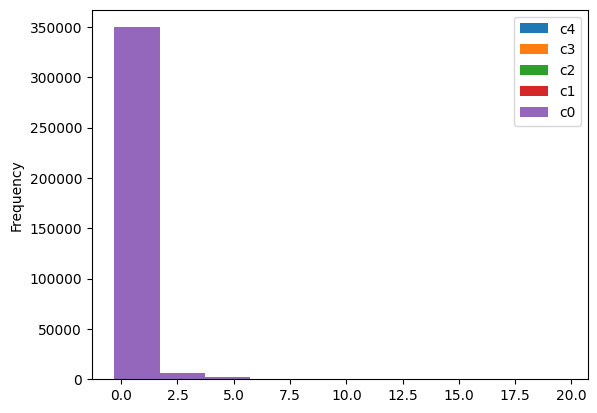

In [17]:
Z.plot(kind='hist')

In [11]:
X.mean()

c4    16.182447
c3    16.181385
c2    16.180172
c1    16.179062
c0    16.177811
dtype: float32

In [12]:
X.std()

c4    53.635124
c3    53.628468
c2    53.620926
c1    53.613201
c0    53.605209
dtype: float32

In [16]:
Z=(X-X.mean())/X.std()